<div align="right" style="text-align: right"><i>Peter Norvig<br>March 2021</i></div>

# The Square-Sum Chain Problem

The Square-Sum Chain Problem is this:

> Rearrange the integers 1 to *n* into a linear chain such that adjacent pairs of integers adds up to a perfect square.

The problem is oft-discussed (e.g., [Numberphile](https://www.youtube.com/watch?v=G1m7goLCJDY), [reddit](https://www.reddit.com/r/dailyprogrammer/comments/7t6fnc/20180126_challenge_348_hard_find_chains/), [MAA](https://www.maa.org/sites/default/files/pdf/awards/college.math.j.46.4.264.pdf), OEIS  [A090460](https://oeis.org/A090460), [A090461](https://oeis.org/A090461) [A071983](https://oeis.org/A071983), [A071984](https://oeis.org/A071984)). There are several variants:

1. Given *n*, find a valid chain.
2. Given *n*, count the number of valid chains.
3. Do this efficiently, for all *n* from 1 up to a largish bound.
5. Require the integers to form a [circular chain](https://www.tutorialspoint.com/statistics/circular_permutation.htm), where the last integer is considered to be adjacent to the first.
6. Do the above with [cubes](https://math.stackexchange.com/questions/1168983/arranging-numbers-from-1-to-n-such-that-the-sum-of-every-two-adjacent-number) (or higher powers) instead of  squares.
4. Prove what happens as *n* goes to infinity.

# Vocabulary

The key concepts for this problem:
- **Chain**: a permutation of the integers 1 to *n*, where each adjacent **pair** sums to a **perfect square**. Implemented as a list.
- **Pair**: two **adjacent** integers in a chain.
- **Circular chain**: a chain that loops back on itself so the first and last integers are **adjacent**.
- **Partial chain**: an incomplete chain that contains only some of the integers 1 to *n*.
- ***n***: the size of the chain. 
- ***i, j***: integers  in the chain.
- ***k***: an index into a chain.
- **Adjacency Graph**: a [graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29) where the vertices are the integers 1 to *n*, and a link between  *i* and *j* means that *i* + *j* is a perfect square. The name reflects both the fact that linked integers in the graph can be adjacent in the chain, and that the graph can be represented with [adjacency lists](https://en.wikipedia.org/wiki/Adjacency_list). Here is the graph for *n* = 15:
[![](SquareSum15.jpg)](http://jackxmorris.com/posts/square-sum)
- **Hamiltonian Path**: a path that visits every vertex in a graph exactly once, such as 8⇒1⇒15⇒10⇒6⇒3⇒13⇒...⇒9 in the graph above.
- **Graph Search**: We can use a [graph search algorithm](https://en.wikipedia.org/wiki/Graph_traversal#Graph_traversal_algorithms) such as [depth-first search](https://en.wikipedia.org/wiki/Depth-first_search) to search for Hamiltonian paths on a graph. Such an algorithm considers **partial chains**, extending them as possible, or discarding them and moving on to alternatives. For example:
  - On the graph above, suppose we have gotten to the partial chain 8⇒1⇒3, which we can represent as the list `[8, 1, 3]`.
  - We will find that there is no way to complete a Hamiltonian path from this partial chain. (If we link to 6 next we will return to 1 a second time; if we link to 13 we will never reach 6.)
  - But we can give up on that chain and consider `[8, 1, 15]`; from there it is easy to find a valid chain.


# Imports, Types, and  Utility Functions

Let's get these out of the way first:

In [1]:
import random
import time
import matplotlib.pyplot as plt
from typing      import *
from math        import sqrt, sin, cos, pi as 𝜋
from collections import Counter, defaultdict

In [2]:
Chain = list                 # A chain of integers, e.g. [8, 1, 15, ...]
Pair  = Tuple[int, int]      # A pair of adjacent integers
Graph = Dict[int, List[int]] # Adjacency graph, e.g. {1: [3, 8, 15], 2: [7, 14], ...}

In [3]:
def first(iterable): "First element, or None."; return next(iter(iterable), None)

def ints(n) -> range: "Integers from 1 to n inclusive."; return range(1, n + 1)

def is_square(n: int) -> bool: "Is `n` a perfect square?"; return sqrt(n).is_integer()

def count(iterable) -> int: 
    "Number of truthy elements in iterable."
    return sum(1 for x in iterable if x)

def pairs(chain, circular=False) -> List[Pair]:
    """All pairs (i, j) of adjacent integers in chain."""
    return [(chain[k - 1], chain[k]) # If `circular` is True, include (chain[-1], chain[0])
            for k in range(1 - circular, len(chain))]

# Adjacency Graphs

Computing an adjacency graph  is straightforward:

In [4]:
def adjacency_graph(n) -> Graph:
    """Build {i: [j, ...]} to indicate that j can be adjacent to i in a chain of length n."""
    return {i: [j for j in ints(n) if i != j and is_square(i + j)]
            for i in ints(n)}

Here is the adjacency graph for *n* = 15. You can verify that it matches the graph shown above.

In [5]:
adjacency_graph(15)

{1: [3, 8, 15],
 2: [7, 14],
 3: [1, 6, 13],
 4: [5, 12],
 5: [4, 11],
 6: [3, 10],
 7: [2, 9],
 8: [1],
 9: [7],
 10: [6, 15],
 11: [5, 14],
 12: [4, 13],
 13: [3, 12],
 14: [2, 11],
 15: [1, 10]}

# Depth-First Graph Search  

I'll define `find_chains(n)` to do the depth-first search to find chains of length `n`. The algorithm is:

  - Precompute the adjacency graph.
  - Assign `stack` to be a stack of partial chains; initially one-element chains, one for each vertex in the graph.
  - On each pass through the `while` loop, pop a partial chain off the stack, and do the following with it:
    - If it is a complete chain (of length `n`), yield it as a valid solution.
    - Otherwise, add new chains to the stack, one for each integer `j` in the adjacency graph that can be added to the partial chain.

For now, only linear chains are allowed. 
Here's the code:

In [6]:
def find_chains(n) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square."""
    graph = adjacency_graph(n)
    stack = [[i] for i in graph]
    while stack:
        chain = stack.pop()
        if len(chain) == n:
            yield chain
        else:
            stack.extend([chain + [j] for j in graph[chain[-1]] if j not in chain])

*Note*: why did I define `find_chains` to be a [generator function](https://docs.python.org/3/howto/functional.html#generators)?  Because that way a single function can be used for two purposes: to efficiently find a single chain for a given *n*, and to exhaustively find all chains for a given *n*. 

# Solving Problems

We can now solve some of the variant problems (at least for small *n* and for linear chains):

In [7]:
n = 15                 # Given n,

In [8]:
any(find_chains(n))    # Are there any valid chains of length n?

True

In [9]:
first(find_chains(n))  # Find a valid chain.

[9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8]

In [10]:
count(find_chains(n)) # Count the number of valid chains.

2

In [11]:
list(find_chains(n))   # List the valid chains.

[[9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8],
 [8, 1, 15, 10, 6, 3, 13, 12, 4, 5, 11, 14, 2, 7, 9]]

Note that these two chains are reversals of each other—you might want to count them as the same chain, but I will count them as two distinct ones.

We can also answer questions "for all *n* up to a bound," although we can't do a very large bound:

In [12]:
{n for n in range(2, 40) if any(find_chains(n))}

{15, 16, 17, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}

# Circular Chains

I'll modify `find_chains` to yield circular chains when the optional argument `circular` is true.

This raises the question of what it means for two chains to be the same or different. If **ABCD** is a circular chain, then **BCDA** is in some sense the same circular chain (i.e., **A**+**D** is a perfect square), just starting from a different place.  I'll use the convention that, I'll only report one starting place for each circular chain, and I'll arbitrarily choose that starting place to be the integer 1. I will however still count reversals (e.g., both **ABCD** and **DCBA**).

In [13]:
def find_chains(n, circular=False) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square.
    If `circular` is true, then chain[0] and chain[-1] are considered adjacent."""
    graph = adjacency_graph(n)
    stack = [[i] for i in ({1} if circular else graph)]
    while stack:
        chain = stack.pop()
        if len(chain) == n and (is_circular(chain) or not circular):
            yield chain
        elif len(chain) < n:
            stack.extend([chain + [j] for j in graph[chain[-1]] if j not in chain])
            
def is_circular(chain) -> bool: "Is `chain` circular?"; return is_square(chain[0] + chain[-1])

What's the smallest *n* that has a valid circular chain?

In [14]:
first(n for n in ints(100) if any(find_chains(n, circular=True)))

32

# Making the Algorithm Faster


As a benchmark, I'll run `find_chains` for  *n* from 1 to 50, check if each *n* has any linear chains, and see how long it takes:

In [15]:
%time count(any(find_chains(n)) for n in ints(50))

CPU times: user 1min 18s, sys: 41.7 ms, total: 1min 18s
Wall time: 1min 18s


31

It took over a minute. Can we speed things up?  It turns out this problem is [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) (according to [Jack Morris](http://jackxmorris.com/posts/square-sum)), so there really is no hope of finding an efficient solution for large *n*. However, there could be optimizationsthat give us constant-factor speedups. 

If we want to find all chains, we need to be resigned to essentially trying all possibilities. But if we are only interested in finding the first chain, we can change the **order** that we consider integers in the chains, to try to make it more likely that the first valid chain shows up earlier in the search. 

What order would be better? One in which we handle the most-constrained hard-to-match integers first–the integers with few links in the adjacency graph. That way, the search will quickly make many moves with little need to back up. For example, on the adjacency graph for *n* = 15, the integer 9 has only one adjacent integer so it comes first, followed by 7, which must be followed by 2 (since 9 is used), which must be followed by 14 (since 7 us used), which must be followed by 11 (since 2 is used), and so on. 

I'll redefine `adjacency_graph` to implement reordering with the function `reorder`, which uses the `link_count`  as the key, but note that I have to reverse the results, because the stack is last-in-first-out, so I need to append the lowest-link-count integer last, so that it will be popped off the stack first.

In [16]:
def adjacency_graph(n) -> Graph:
    """{i: [j, ...]} with i's and j's sorted by most links first."""
    graph = {i: [j for j in ints(n) if i != j and sqrt(i + j).is_integer()]
            for i in ints(n)}
    def link_count(i): return len(graph[i])
    def reorder(integers): return sorted(integers, key=link_count, reverse=True)
    return {i: reorder(graph[i]) for i in reorder(graph)}

In [17]:
adjacency_graph(n) # Reordered with the leaf 9 last; each list is reordered as well.

{1: [3, 15, 8],
 3: [1, 6, 13],
 2: [7, 14],
 4: [5, 12],
 5: [4, 11],
 6: [3, 10],
 7: [2, 9],
 10: [6, 15],
 11: [5, 14],
 12: [4, 13],
 13: [3, 12],
 14: [2, 11],
 15: [1, 10],
 8: [1],
 9: [7]}

Will this new version of `adjacency_graph` give us a good speedup? (Note we haven't changed `find_chains` at all.)

In [18]:
%time count(any(find_chains(n)) for n in ints(50))

CPU times: user 870 ms, sys: 2.21 ms, total: 872 ms
Wall time: 871 ms


31

That was a nice improvement! Nearly 100× faster on this particular benchmark! 

I have another idea, which should give a small speedup. The idea is to manage a [bitstring](https://en.wikipedia.org/wiki/Bit_array) to represent the integers in the chain, so that the test `if j not in chain` becomes an O(1) lookup, not an O(*n*) linear search. Instead of a stack entry being a chain like `[9, 7, 2]`, it would  become a tuple like `([9, 7, 2], 0b1010000100)`, where `0b1010000100` means that the 9th, 7th, and 2nd bits are on (counting from 0 on the right). 

I'll also change the `stack.extend` to a `stack.append` inside a `for` loop, because the statement won't fit on one line anymore. This does give us the opportunity to save a little bit of time and memory by returning a chain as soon as it has length `n`, rather than putting it on the stack and popping it off later. 

In [19]:
old_find_chains = find_chains

In [20]:
def find_chains(n, circular=False) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square.
    If `circular` is true, then chain[0] and chain[-1] are considered adjacent."""
    graph = adjacency_graph(n)
    stack = [([i], 1 << i) for i in ({1} if circular else graph)]
    while stack:
        chain, bits = stack.pop()
        for j in graph[chain[-1]]:
            if not bits & (1 << j):
                newchain = chain + [j]
                newbits  = bits | (1 << j)
                if len(newchain) == n and (is_circular(newchain) or not circular):
                    yield newchain
                elif len(newchain) < n:
                    stack.append((newchain, newbits))

In [21]:
%time count(any(find_chains(n)) for n in ints(50))

CPU times: user 539 ms, sys: 2.43 ms, total: 542 ms
Wall time: 540 ms


30

That's about a 40% improvement; better than I hoped for! 

But note that the two versions of `find_chains` give **different answers** for *n* = 1. The original version said that `[1]` is a valid linear chain (which makes sense because it is a permutation of the integers from 1 to 1, and every pair sums to a perfect square, because there are no pairs). In contrast, the revised version says that `[1]` is not a valid chain (which also makes sense if you interpret the problem as saying that all integers in the chain have to be part of a pair that forms a perfect square). Which interpretation is correct? There's no definitive answer. (Likewise for the question of whether `[]` is a valid chain for *n* = 0.) 

# Visualization

I'd like to understand more about chains, with an emphasis on circular ones. Visualizations can help. The function `circle` takes as input either a chain or an adjacency graph of size *n*, and does the following:
- Plot the integers 1 to *n* as vertices in a circle, in clockwise order like a clock face.
- Plot lines between integers to indicate a link (the links in a chain, or all the links in an adjacency graph).
  - All lines with the same *i* + *j* sum will be of the same color, and will be parallel to each other.
- Print the [*degree counts*](https://en.wikipedia.org/wiki/Degree_%28graph_theory%29): the number of vertices (integers) with each degree. <br> (`{1: 2, 2: 11, 3: 1}` means there are 2 vertices (leaves) with 1 link;  11 vertices with two links; and 2 vertices with 3 links.)
- Print the number of links that sum up to each perfect square.<br>(`{4: 1, 9: 4, 16: 7, 25: 3}` means that there is 1 link whose integers sum to 4; 4 that sum to 9; 7 that sum to 16; and 3 that sum to 25.)

In [22]:
def circle(x: Union[Chain, Graph]):
    """Visualize a graph or chain as a circle."""
    chain, graph = (x, graph_of(x)) if isinstance(x, Chain) else ([], x)
    n = max(graph)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis('off')
    𝛼 = 2 * 𝜋 / n
    X = [sin(𝛼 * i) for i in ints(n)]
    Y = [cos(𝛼 * i) for i in ints(n)]
    for i in graph:             
        for j in graph[i]:      # Draw edges
            color = colors[int(sqrt(i + j)) % len(colors)]
            plt.plot([X[i-1], X[j-1]], [Y[i-1], Y[j-1]], '-', color=color)
    ax.scatter(X, Y, color='k') # Draw vertices
    for i in ints(n):           # Draw integers next to vertices
        vertex = (X[i - 1] * 1.1 - 0.02, Y[i - 1] * 1.1 - 0.02)
        ax.annotate(i, vertex, annotation_clip=False)
    def ctr(seq): return dict(sorted(Counter(seq).items())) # sorted Counter
    print('Degree counts:', ctr(map(len, graph.values())))
    print('Square counts:', ctr(i + j for i in graph for j in graph[i] if i > j))
    if chain: print('Chain:', '-'.join(map(str, chain)))
        
colors = 'c m y r g b orange lime deeppink brown silver'.split()

def graph_of(chain: Chain) -> Graph:
    """Convert a chain, [i, j, ...] to a graph, {i: [j, ...], ...}."""
    graph = defaultdict(list)
    for i, j in pairs(chain, is_circular(chain)):
        graph[i].append(j)
        graph[j].append(i)
    return graph

# Visualizing a linear chain for *n* = 15

Below is the chain for *n* = 15, followed by the adjacency graph (which is the same except for one more link, the yellow link between 1 and 3).

Degree counts: {1: 2, 2: 13}
Square counts: {9: 4, 16: 7, 25: 3}
Chain: 9-7-2-14-11-5-4-12-13-3-6-10-15-1-8


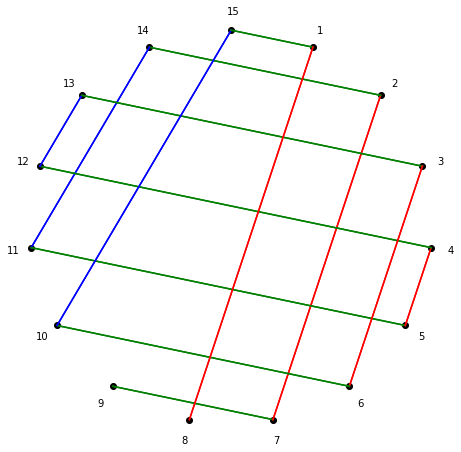

In [23]:
circle(first(find_chains(15)))

Degree counts: {1: 2, 2: 11, 3: 2}
Square counts: {4: 1, 9: 4, 16: 7, 25: 3}


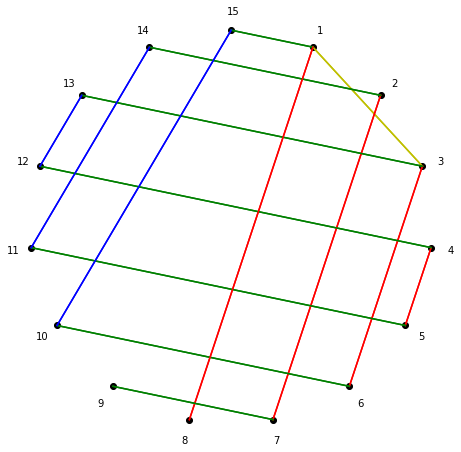

In [24]:
circle(adjacency_graph(15))

The adjacency graph for *n* = 15 shows that 9 and 8 have only one link each (and thus must be the endpoints of any valid chain). There are also 11 different integers with  2 links each, meaning that their position in the chain is fixed–there is no choice about what their adjacent numbers will be. The only choice points are the two integers that each have 3 links: 1 and 3.

# Visualizing a circular chain for *n* = 32

Degree counts: {2: 32}
Square counts: {9: 2, 16: 4, 25: 6, 36: 12, 49: 8}
Chain: 1-15-10-26-23-2-14-22-27-9-16-20-29-7-18-31-5-11-25-24-12-13-3-6-30-19-17-32-4-21-28-8


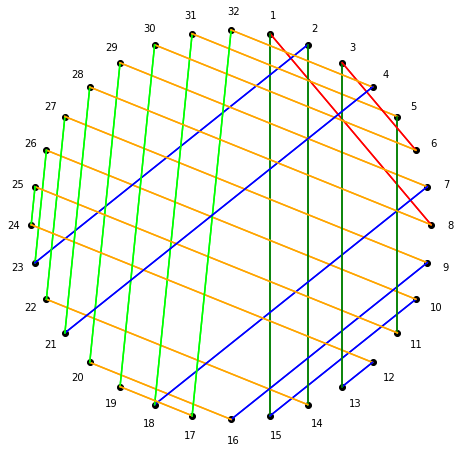

In [25]:
circle(first(find_chains(32, circular=True)))

Degree counts: {2: 10, 3: 16, 4: 6}
Square counts: {4: 1, 9: 4, 16: 7, 25: 12, 36: 14, 49: 8}


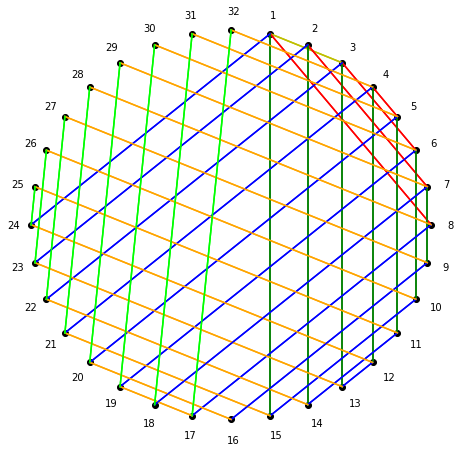

In [26]:
circle(adjacency_graph(32))

It is interesting that the chain keeps all 8 of the (lime) links that add up to 49, and 12 of the 14 (orange) links that add up to 36, but that links with lower sums are less likely to appear in the chain.

# Visualizing chains for other values of *n*
Some more pretty pictures:

Degree counts: {2: 42}
Square counts: {9: 3, 16: 3, 25: 4, 36: 8, 49: 14, 64: 9, 81: 1}
Chain: 1-35-29-20-16-33-31-18-7-42-39-25-24-40-9-27-37-12-13-36-28-21-15-34-30-19-17-32-4-5-11-38-26-10-6-3-22-14-2-23-41-8


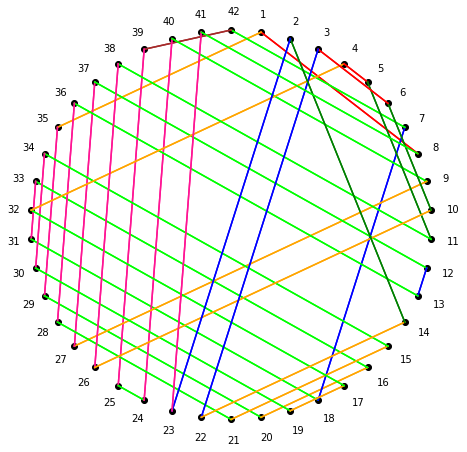

In [27]:
circle(first(find_chains(42, True)))

Degree counts: {2: 36}
Square counts: {9: 1, 16: 6, 25: 4, 36: 11, 49: 11, 64: 3}
Chain: 1-35-29-20-16-33-3-13-36-28-21-15-34-30-19-6-10-26-23-2-14-22-27-9-7-18-31-5-11-25-24-12-4-32-17-8


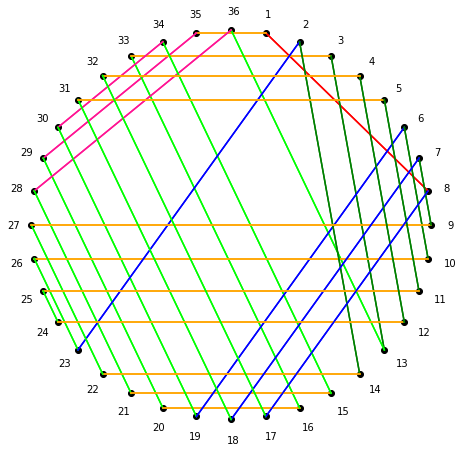

In [28]:
circle(first(find_chains(36, True)))

Degree counts: {1: 2, 2: 48}
Square counts: {9: 4, 16: 6, 25: 4, 49: 10, 64: 15, 81: 10}
Chain: 50-31-18-46-35-29-20-44-37-27-22-42-39-25-24-40-41-23-26-38-43-21-28-36-45-19-30-34-47-17-32-49-15-10-6-3-13-12-4-5-11-14-2-7-9-16-33-48-1-8


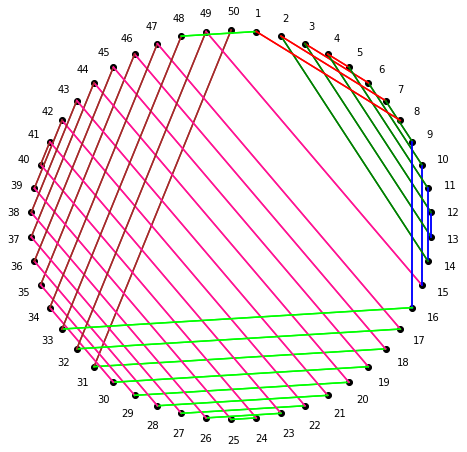

In [29]:
circle(first(find_chains(50, False)))

Degree counts: {1: 2, 2: 68}
Square counts: {9: 3, 16: 5, 25: 6, 36: 6, 49: 7, 64: 4, 81: 10, 100: 18, 121: 10}
Chain: 50-31-69-52-48-33-67-54-46-18-63-58-42-39-61-60-40-41-59-62-38-43-57-64-36-45-55-66-34-47-53-68-32-49-51-70-30-19-17-8-56-65-35-29-20-16-9-7-2-23-26-10-6-3-13-12-4-5-44-37-27-22-14-11-25-24-1-15-21-28


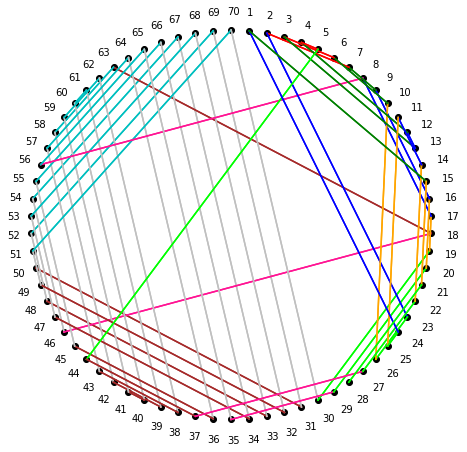

In [30]:
circle(first(find_chains(70)))

Degree counts: {2: 1, 3: 8, 4: 33, 5: 16, 6: 10, 7: 2}
Square counts: {4: 1, 9: 4, 16: 7, 25: 12, 36: 17, 49: 24, 64: 31, 81: 30, 100: 20, 121: 10}


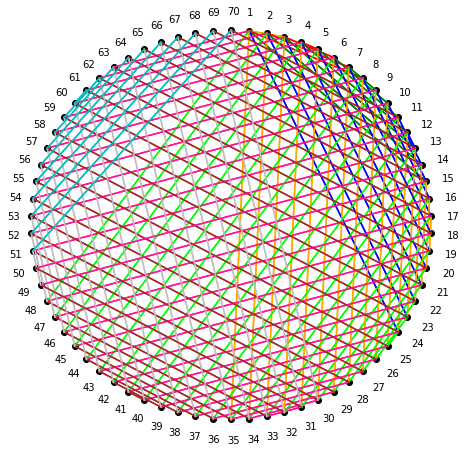

In [31]:
circle(adjacency_graph(70))

# Charts of Counts and Run Times

The circle plots above give me some insight into chains for individual values of *n*. Now I want to summarize results over a range of values for *n*, with a chart showing the results of calls to `find_chains`, and another chart showing how much time each computation took.


In [32]:
def charts(N, what=count, circular=False):
    """Call what(find(chains(n, circular)) for all n in ints(N); chart results."""
    fn = lambda n: what(find_chains(n, circular))
    results, times = transpose(benchmark(fn, ints(N)))
    found = [n for (n, r) in zip(ints(N), results) if r]
    print(f'{what.__name__} {"circular" if circular else "linear"} chains for n up to {N}')
    print(f'Chains found for n = {group_consecutive(found)}')
    print(f'Total time: {sum(times):.1f} seconds')
    if what == any:
        plt.yticks([0, 1], ['No', 'Yes'])
        plot(ints(N), results, 'b+', 'Any chains?')
    else:
        plot(ints(N), results, 'b+-', 'Number of chains')
    plt.show()
    plot(ints(N), times, 'm+-', 'Time in seconds', )
    
def plot(X, Y, style, ylabel='', xlabel='chain size, n'):
    """A convenient way to call plt.plot with labels."""
    plt.plot(X, Y, style); plt.ylabel(ylabel); plt.xlabel(xlabel)
    
def benchmark(fn, inputs):
    """Yield (result, runtime) for each fn(input)."""
    for input in inputs:
        t0 = time.process_time()
        yield fn(input), time.process_time() - t0
    
def transpose(matrix): return zip(*matrix)

I'll define a `Group` as a list of integers that prints succinctly: `[15, 16, 17]` prints as `'15-17'`.

In [33]:
class Group(list):
    """A group of integers."""
    def __repr__(self): return f'{min(self)}{f"-{max(self)}" if len(self) > 1 else ""}'

def group_consecutive(integers):
    """Group integers into sublists of consecutive integers."""
    groups = []
    for n in sorted(integers):
        if not groups or n != max(groups[-1]) + 1:
            groups.append(Group())
        groups[-1].append(n)
    return groups


Below I will call `charts` with different parameter values:
- `N`: A small bound that makes the total run time about a second, and a larger bound that makes it about a minute.
- `what`: Both `any` to see if there are any solutions (for each value of *n*), and `count` to count them.
- `circular`: Both `True` and `False` (the default).

# Any Linear Chain

any linear chains for n up to 71
Chains found for n = [15-17, 23, 25-71]
Total time: 1.0 seconds


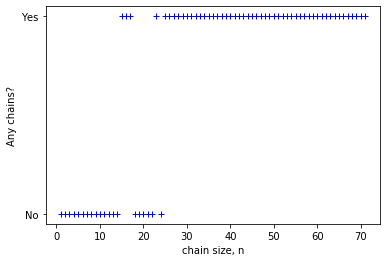

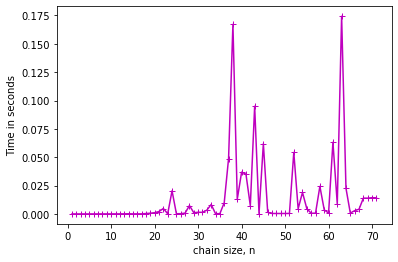

In [34]:
charts(71, any)

any linear chains for n up to 84
Chains found for n = [15-17, 23, 25-84]
Total time: 30.5 seconds


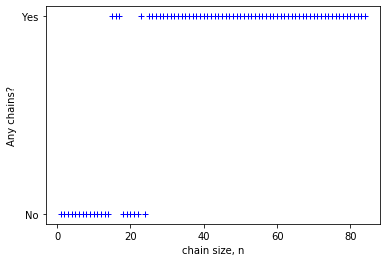

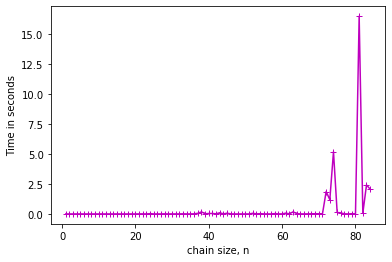

In [35]:
charts(84, any)

# Any Circular Chain


any circular chains for n up to 45
Chains found for n = [32-45]
Total time: 1.6 seconds


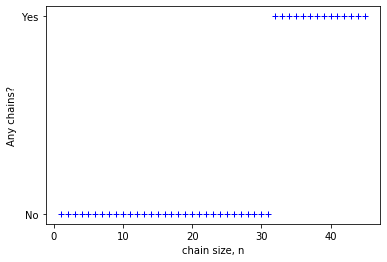

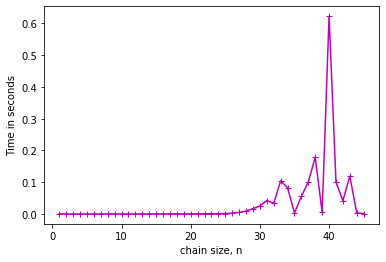

In [36]:
charts(45, any, True)

any circular chains for n up to 46
Chains found for n = [32-46]
Total time: 52.6 seconds


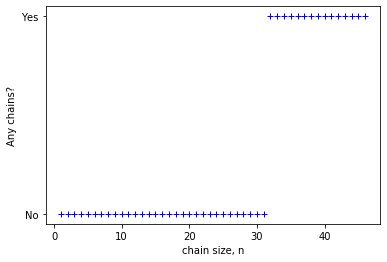

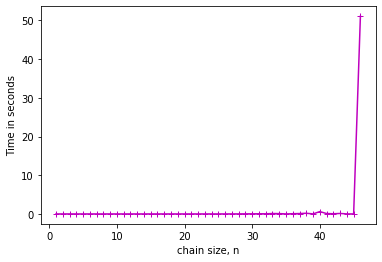

In [37]:
charts(46, any, True)


# Counting Linear Chains

count linear chains for n up to 30
Chains found for n = [15-17, 23, 25-30]
Total time: 2.2 seconds


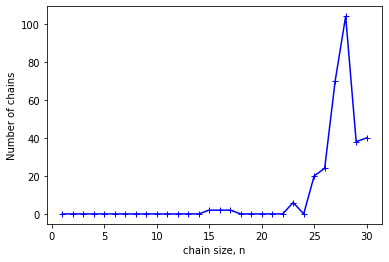

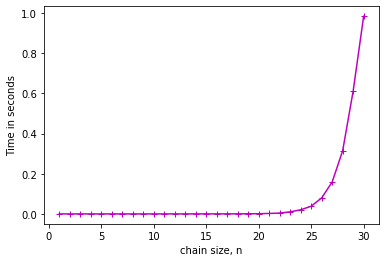

In [38]:
charts(30, count)

count linear chains for n up to 34
Chains found for n = [15-17, 23, 25-34]
Total time: 47.8 seconds


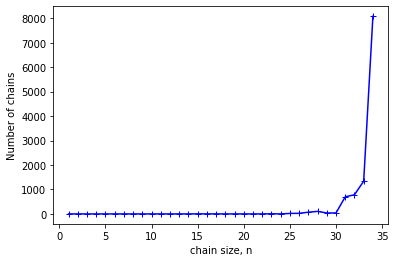

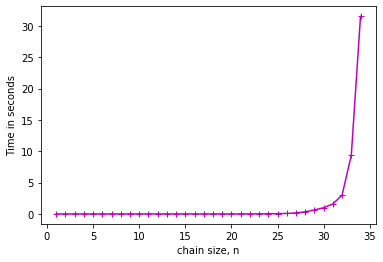

In [39]:
charts(34, count)

# Counting Circular Chains

count circular chains for n up to 34
Chains found for n = [32-34]
Total time: 1.2 seconds


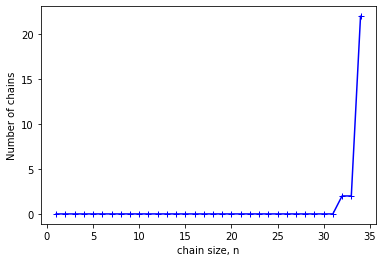

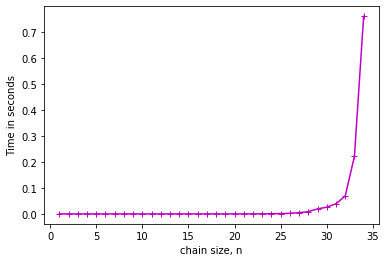

In [40]:
charts(34, count, True)

count circular chains for n up to 40
Chains found for n = [32-40]
Total time: 85.2 seconds


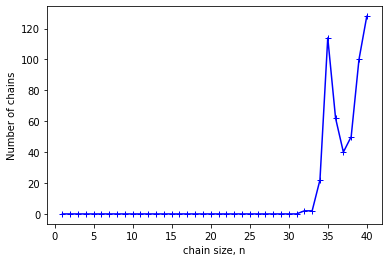

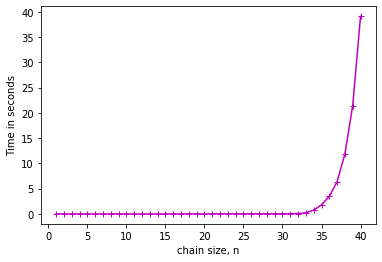

In [41]:
charts(40, count, True)

My conclusions from these charts:

- The run time to find the first chain is mostly increasing, but sporadic; it depends on if we make "lucky" early guesses.
- The run time to find all chains looks exponential.
- There are more linear chains than circular chains (for *n* = 34: 8082 linear chains, 22 circular chains).
- The number of chains  does not monotonically increase with *n*.


# Tests

Here is a small test suite.

In [42]:
def test():
    assert is_square(49)
    assert not is_square(42)
    assert is_circular([1, ..., 8])
    assert not is_circular([1, ..., 9])
    assert is_chain([9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8])
    assert not is_chain([2, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8])
    assert not is_chain([7, 9, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8])
    assert all(is_chain(c) for c in find_chains(23))
    assert all(is_chain(c, True) for c in find_chains(32, True))
    assert first(map(abs, [-1, 2, -9])) == 1
    assert count(map(abs, [-1, 2, -9])) == 3
    assert count(find_chains(23)) == 6
    assert ints(10) == range(1, 11)
    assert pairs([1, 2, 3]) == [(1, 2), (2, 3)]
    assert pairs([1, 2, 3], circular=True) == [(3, 1), (1, 2), (2, 3)]
    assert adjacency_graph(9) == {
        1: [3, 8], 2: [7], 3: [1, 6], 4: [5], 5: [4], 6: [3], 7: [2, 9], 8: [1], 9: [7]}
    assert count(any(find_chains(n)) for n in ints(50)) == 30
    assert graph_of([1, 2, 3]) == {1: [3, 2], 2: [1, 3], 3: [1, 2]}
    assert graph_of([1, 2, 9]) == {1: [2], 2: [1, 9], 9: [2]}
    assert repr(Group([15, 16, 17])) == '15-17'
    assert repr(group_consecutive({15, 16, 17, 2, 3, 5, 7, 8, 9})) == '[2-3, 5, 7-9, 15-17]'
    
def is_chain(chain, circular=False): 
    """Is this a valid chain?"""
    return (sorted(chain) == sorted(ints(len(chain))) and
            all(is_square(sum(pair)) for pair in pairs(chain, circular)))
    
test()

# The Road Not Taken

Here are a few ideas that you are welcome to follow up on:

- **Leaves**: Looking at the graph diagram for *n* = 15 (or at the adjacency dict), we see that both 8 and 9 only link to one other number; they are **leaves** in the graph. That means that they must be the endpoints in any valid chain. For *n* = 15, we could limit the partial chains in the initial stack to just `[8]` and `[9]`, and if `circular` is true, we could immediately return with no solutions.
- **Incremental Chains**: Given the chain for *n* = 15, we could form a chain for *n* = 16 by just placing 16 next to the endpoint 9. No search required. 
- **Reversals**: For every valid chain, there is another valid chain that is its reversal. Can you use this fact to cut the amount of search in half?
- **Dynamic Reordering**: Instead of reordering the adjacency lists once and for all at the start of the search, dynamically update the counts (and thus the ordering of the lists) as integers are used in partial chains. Backtrack when there are more leaves than endpoints in the chain.
- **Hillclimbing**: use [hillclimbing search](https://en.wikipedia.org/wiki/Hill_climbing) to modify a partial solution. You could have the search for a solution for *n* begin with a solution chain for *n - 1*, and search in the space of edit operations on that chains: insert *n* into that chain; cut a chain into  two parts; reverse a part; append two parts together; etc. 
